In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats, scipy.special, scipy.linalg

# Regression

We follow [Gelman et al. "Bayesian Data Analysis 2nd Ed."](https://www.amazon.co.uk/Bayesian-Analysis-Chapman-Statistical-Science-ebook/dp/B00I60M6H6) Chapter 14.

[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) tries to "fit a line to data".  The model is that we have data points $(x_i, y_i)$ and we try to fit a line through this data, subject to a linear error term
$$ y_i = \alpha + \beta x_i + \epsilon_i $$
where we assume $(\epsilon_i)$ are iid draws from a normal distribution with mean 0 and variance $\sigma^2$.

Set $\beta_1 = \alpha$, $\beta_2 = \beta$ and set $x_{i,1} = 1$ and $x_{i,2} = x_i$ for each $i$.  Then the above is equivalent to 
$$ y_i \sim N( \beta x_i, \sigma^2 ) $$
where we use vector notation $\beta x_i = \beta_1 x_{i,1} + \beta_2 x_{i,2}$.  That is, the $(y_i)$ are independent and each distributed normally with mean $\beta x_i$ and (common) variance $\sigma^2$.

This new form allows extension to many dimensions.  We often (but are not required to) set $x_{i,1}=1$ constantly.

If we write the $(x_i)$ as a matrix
$$ X = \begin{pmatrix} x_{1,1} & x_{1,2} & \cdots & x_{1,k} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,k} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1} & x_{n,2} & \cdots & x_{n,k} \end{pmatrix}, \quad
\beta = \begin{pmatrix} \beta_1 \\ \beta_2 \\ \vdots \\ \beta_k \end{pmatrix} $$
Then our model (ordinary linear regression) is that
$$ y \, |\,  \beta, \sigma^2, X \sim N(X\beta, \sigma^2 I) $$
where $I=I_n$ is the $n\times n$ identity matrix.  More complicated models may replace this with a more general positive definite matrix.

## Bayesian approach

Classical regression would seek point estimates for $\sigma^2$ and $\beta$.  A (simple) Bayesian approach is to place a prior on these, and then seek the Posterior distribution.  Following Gelman et al. we use a noninformative prior
$$ p(\beta, \sigma^2 | X) \propto \sigma^{-2}. $$

This has the advantage that we can analytically compute the posterior, and make links with classical regression.  Set
\begin{align*}
\hat\beta &= (X^TX)^{-1} X^T y \\
V_\beta &= (X^TX)^{-1} \\
s^2 &= \frac{1}{n-k} (y-X\hat\beta)^T(y-X\hat\beta)
\end{align*}
Then
$$ \beta | \sigma^2, y \sim N(\hat\beta, \sigma^2 V_\beta $$
and so knowing $\sigma^2$ (and the data) we can draw samples from $\beta$.  Further,
$$ \sigma^2 | y \sim \operatorname{Inv-}\chi^2(n-k, s^2). $$
This is the [scaled inverse-$\chi^2$ distribution](https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution).

As the book helpful points out:
- This is the same as the [Inverse Gamma](https://en.wikipedia.org/wiki/Inverse-gamma_distribution) distribution with $\alpha = (n-k)/2$ and $\beta = \alpha s^2$.
- To sample from an inverse gamma, we simply sample $\theta$ from a Gamma distribution with parameters $\alpha,\beta$ and then return $\theta^{-1}$
- Alternatively, we sample $\theta$ from $\chi^2_{n-k}$ and then return $(n-k)s^2/\theta$.

In [2]:
df = 5
s2 = 10

x = np.random.chisquare(df, size=10000)
theta1 = df * s2 / x

alpha = df / 2
beta = alpha * s2
x = np.random.gamma(alpha, 1/beta, size=10000)
theta2 = 1 / x

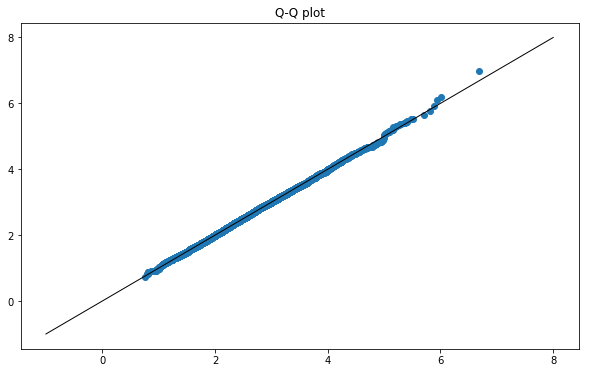

In [3]:
fig, ax = plt.subplots(figsize=(10,6))

t1 = np.sort(np.log(theta1))
t2 = np.sort(np.log(theta2))
ax.scatter(t1, t2)
ax.plot([-1,8], [-1,8], linewidth=1, color="black")
ax.set_title("Q-Q plot")
None

## Simulate some data

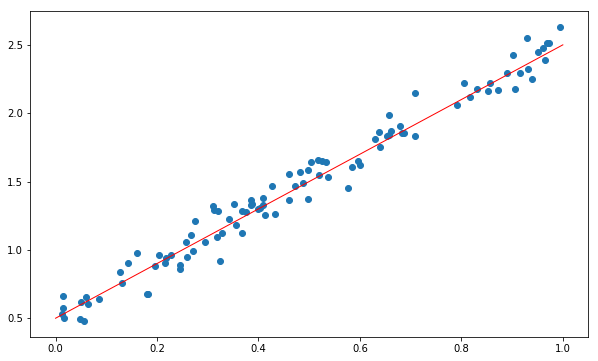

In [4]:
beta_real = np.asarray([0.5, 2]).T
x = np.random.random(100)
e = np.random.normal(scale=.1, size=len(x))
x = np.vstack([[1]*len(x),x]).T
y = np.dot(x, beta_real) + e

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x[:,1], y)
ax.plot([0,1],np.dot([[1,0],[1,1]], beta_real), linewidth=1, color="red")

## Fit the data

In [5]:
V = scipy.linalg.inv(np.dot(x.T, x))
beta_hat = np.dot(np.dot(V, x.T), y)
error = y - np.dot(x, beta_hat)
s2 = np.dot(error.T, error) / (x.shape[0] - x.shape[1])
beta_hat, V, s2

(array([ 0.50168526,  2.02720384]), array([[ 0.03927551, -0.06156826],
        [-0.06156826,  0.12948194]]), 0.0087098479786871623)

In [6]:
def sample_inv_gamma(df, s2, size=1):
    x = np.random.chisquare(df, size=size)
    return df * s2 / x

sigma2 = sample_inv_gamma(x.shape[0] - x.shape[1], s2, size=10000)
beta = np.asarray([np.random.multivariate_normal(beta_hat, var * V) for var in sigma2])

In [7]:
def plot(beta, sigma2):
    xcoords = np.vstack([[1]*100, np.linspace(0,1,100)])
    ycoords = np.sum(beta[:,:,None] * xcoords[None,:,:], axis=1)
    y_mean = np.mean(ycoords, axis=0)
    lower, upper = np.percentile(ycoords, 5, axis=0), np.percentile(ycoords, 95, axis=0)

    ypred = ycoords + np.random.normal(0, np.sqrt(sigma2))[:,None]
    ypred_mean = np.mean(ypred, axis=0)
    plower, pupper = np.percentile(ypred, 5, axis=0), np.percentile(ypred, 95, axis=0)

    fig, axes = plt.subplots(ncols=3, figsize=(16,6))

    ax = axes[0]
    ax.plot([0,1],np.dot([[1,0],[1,1]], beta_real), linewidth=1, color="red")
    ax.plot(xcoords[1], y_mean, linewidth=1, color="black")
    ax.fill_between(xcoords[1], lower, upper, color="grey")
    ax.scatter(x[:,1], y, marker="x", color="black", linewidth=1)
    ax.set_title("Mean and 90% confidence interval")

    ax = axes[2]
    ax.plot(xcoords[1], ypred_mean, linewidth=1, color="black")
    ax.fill_between(xcoords[1], plower, pupper, color="grey")
    ax.set_title("Predictive distribution")

    ax = axes[1]
    ker = scipy.stats.kde.gaussian_kde(np.log(sigma2))
    xc = np.linspace(-6, -4, 200)
    ax.plot(xc, ker(xc))
    ax.set(xlabel="$\log \sigma^2$", title="Distribution of $\sigma^2$")
    
    return fig

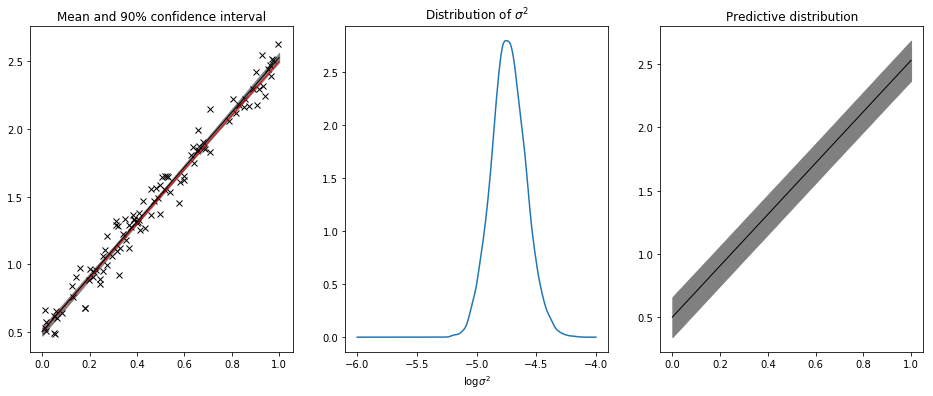

In [8]:
_ = plot(beta, sigma2)

# Computational approach

We have
$$ p(y|X,\beta,\sigma^2)
= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\Big(-\frac{(y-X\beta)_i^2}{2\sigma^2}\Big)
= (2\pi\sigma^2)^{-n/2} \exp\Big(-\frac{\|y-X\beta\|^2}{2\sigma^2}\Big)
$$

In [9]:
import corner
import emcee

In [10]:
def data_log_likelihood(p, data):
    """
    :param p: Array where first entry is :math:`sigma^2` and the rest is beta.
    :param data: `(x,y)`
    """
    sigma2 = p[0]
    beta = p[1:]
    x, y = data
    n = len(y)
    ll = np.log(2 * np.pi * sigma2) * (-n/2)
    xb = y - np.dot(x, beta)
    ll -= np.dot(xb.T, xb) / (2 * sigma2)
    return ll

def log_likelihood(p, data):
    sigma2 = p[0]
    if sigma2 <= 0:
        return -np.inf
    ll = -np.log(sigma2)
    return ll + data_log_likelihood(p, data)

In [11]:
nwalkers = 10
p0 = np.random.rand(3 * nwalkers).reshape((nwalkers, 3))

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, 3, log_likelihood, args=((x,y),))

In [13]:
pos, prob, state = sampler.run_mcmc(p0, 1000)
sampler.reset()

In [14]:
_ = sampler.run_mcmc(pos, 20000)

In [15]:
samples = sampler.flatchain

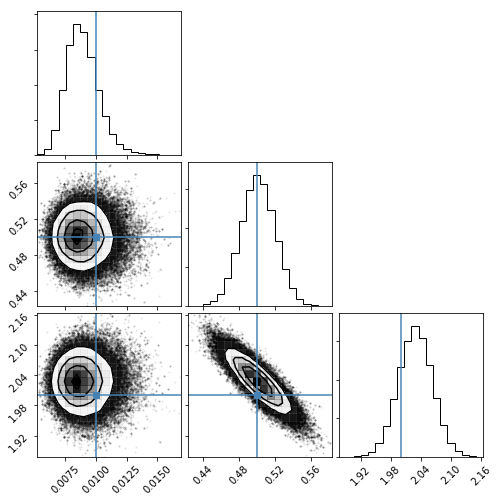

In [16]:
_ = corner.corner(samples, truths=[0.1**2, beta_real[0], beta_real[1]])

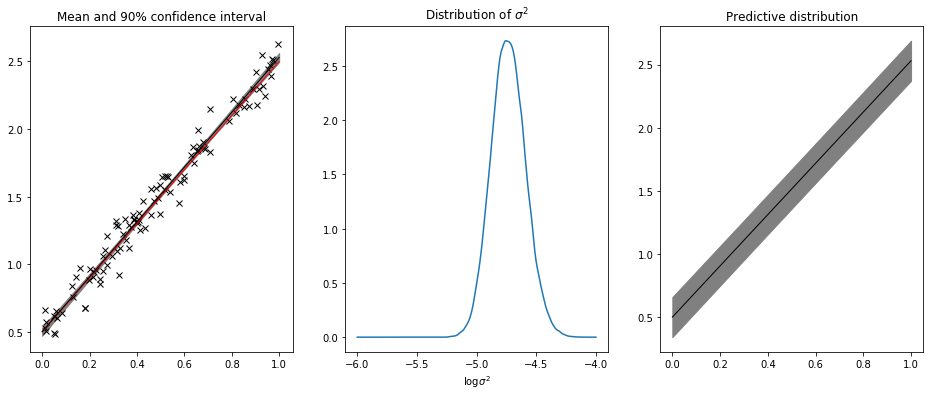

In [17]:
beta = samples[:,1:]
sigma2 = samples[:,0]
_ = plot(beta, sigma2)

## Use a different prior

Let's assume $\beta_i \sim N(0, 1)$ and $\sigma^2 \sim \operatorname{Exp}(1)$

Turns out it doesn't matter (data dominates...)

In [18]:
def log_likelihood(p, data):
    sigma2, beta = p[0], p[1:]
    if sigma2 <= 0:
        return -np.inf
    ll = -sigma2
    ll -= np.log(2 * np.pi * 1) * (len(beta)/2) - np.sum(beta*beta) / 2
    return ll + data_log_likelihood(p, data)

In [19]:
nwalkers = 10
p0 = np.random.rand(3 * nwalkers).reshape((nwalkers, 3))

sampler = emcee.EnsembleSampler(nwalkers, 3, log_likelihood, args=((x,y),))

pos, prob, state = sampler.run_mcmc(p0, 1000)
sampler.reset()

_ = sampler.run_mcmc(pos, 20000)

samples = sampler.flatchain

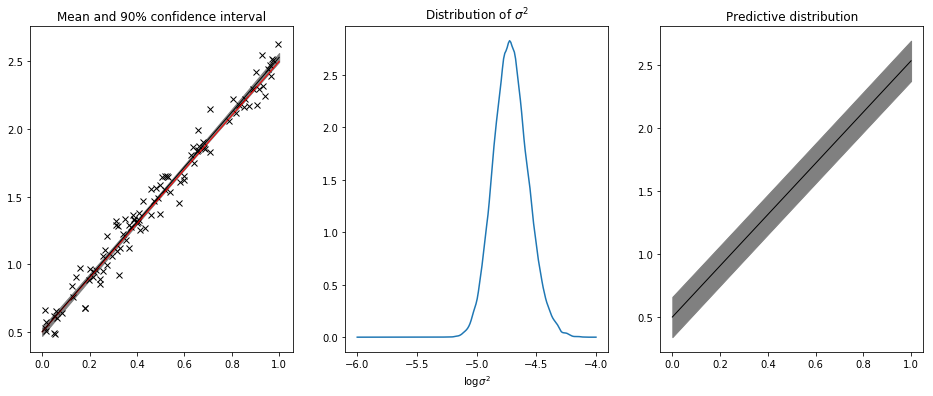

In [20]:
beta = samples[:,1:]
sigma2 = samples[:,0]
_ = plot(beta, sigma2)

# TODO: Pymc3